## Multi-Agent System for Conversational Data Analysis and Visualization
This notebook defines and executes a modular, intelligent multi-agent system designed to analyze and visualize public sector data through natural language queries.

The system is composed of three main agents:
- ConversationAgent: understands user intent and routes the query.
- DataProcessingAgent: generates and executes analysis code.
- VisualizationAgent: produces charts and graphical summaries.

All agents communicate and cooperate via shared tools and a memory buffer, and the entire interaction is orchestrated in a transparent and explainable way using the OpenAI Agent SDK.


# How to Run
To run this project locally and ensure everything works as expected, follow these steps:

### 1. Download or clone the repository
```bash
git clone https://github.com/paolinamazza/Multi-Agent-Ststem.git
cd Multi-Agent-System
```

### 2. Create and activate a virtual environment
It is highly recommended to use a virtual environment to avoid conflicts with other Python packages.
**On macOS/Linux:**
```bash
python3 -m venv venv
source venv/bin/activate
```
**On Windows:**
```bash
python -m venv venv
venv\Scripts\activate
```

### 3. Install all dependencies
You can recreate the whole Python environment by just running:
```bash
pip install -r requirements.txt
```
This will install all required libraries (such as openai, streamlit, pandas, matplotlib, etc.) listed in the requirements.txt file.

### 4. Run the application
To directly try our agents, you can run Streamlit in one of the following ways:
- **A)** Going to the end of the `main.ipynb` notebook in the Streamlit section and running the cell: ```bash !streamlit run app.py ``` 
- **B)** by running from the root of the repository ```bash streamlit run app.py ```
After these steps, the Streamlit interface will open in your browser, allowing you to interact with the agents through a chat-based interface.



# Import Libraries

We load all the essential libraries and components:
- Custom agents and tools (Agent, function_tool, Runner, etc.)
- Data handling and visualization libraries: pandas, matplotlib, seaborn, numpy
- Token-aware memory management (tiktoken)
- File management and .env configuration (os, dotenv)
- LlamaIndex modules for optional semantic matching and indexing
- Error handling and type validation utilities
- These tools work together to allow the system to:
- Interpret complex user queries,
- Generate executable Python code,
- Visualize or explain results clearly,
- Maintain memory for multi-turn conversations.


In [ ]:
from agents import Agent, InputGuardrail,GuardrailFunctionOutput, Runner
from agents import ModelSettings, function_tool
from pydantic import BaseModel
import asyncio
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import io
import base64
from pandas.api.types import CategoricalDtype
from typing import Dict
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, ServiceContext, load_index_from_storage
from llama_index.core.storage.storage_context import StorageContext
from llama_index.llms.openai import OpenAI
from dotenv import load_dotenv
import os
import contextlib
import traceback
import tiktoken  

# Data Loading & Exploration


In [125]:
# Load datasets from uploaded files
df_accesso = pd.read_csv("EntryAccessoAmministrati_202501.csv")
df_pendolarismo = pd.read_csv("EntryPendolarismo_202501.csv")
df_amministrati = pd.read_csv("EntryAmministratiPerFasciaDiReddito_202501.csv")
df_stipendi = pd.read_csv("EntryAccreditoStipendi_202501.csv")


### df_accesso

In [126]:
print(df_accesso.info())
print("Null values:")
print(df_accesso.isnull().sum())
print("\n")
print(df_accesso.dtypes)
print("\nGender Distribution (%):")
print(df_accesso["sesso"].value_counts(normalize=True) * 100)
print("\nAuthentication method's distribution (%):")
print(df_accesso["modalita_autenticazione"].value_counts(normalize=True) * 100)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528 entries, 0 to 8527
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   regione_residenza_domicilio   8528 non-null   object
 1   amministrazione_appartenenza  8528 non-null   object
 2   sesso                         8528 non-null   object
 3   eta_max                       8528 non-null   object
 4   eta_min                       8528 non-null   int64 
 5   modalita_autenticazione       8528 non-null   object
 6   numero_occorrenze             8528 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 466.5+ KB
None
Null values:
regione_residenza_domicilio     0
amministrazione_appartenenza    0
sesso                           0
eta_max                         0
eta_min                         0
modalita_autenticazione         0
numero_occorrenze               0
dtype: int64


regione_residenza_domicilio     object
amministra


Top regions by number of accesses:
regione_residenza_domicilio
CAMPANIA          218307
LAZIO             218154
SICILIA           176240
LOMBARDIA         144864
PUGLIA            135710
VENETO             78402
PIEMONTE           77319
CALABRIA           76061
TOSCANA            75731
EMILIA ROMAGNA     75355
Name: numero_occorrenze, dtype: int64


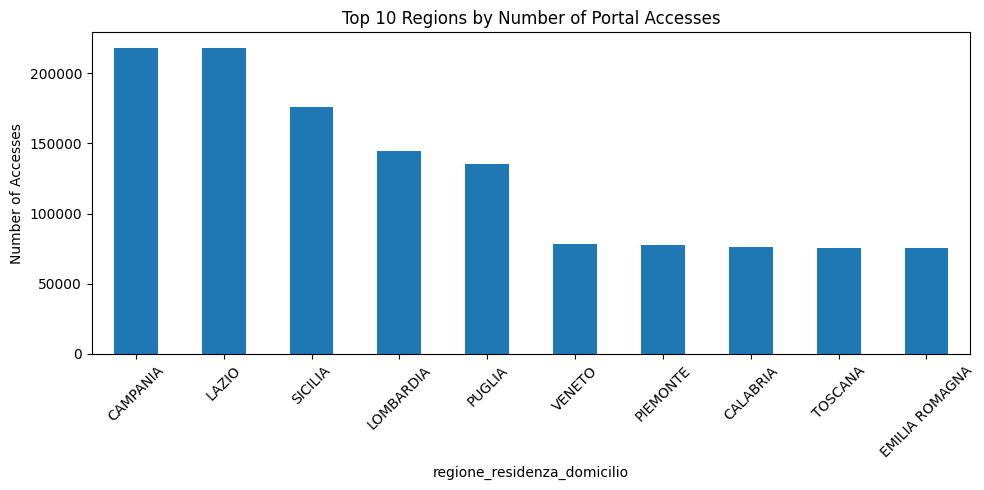


Authentication Method Distribution:
modalita_autenticazione
SPID          1406625
CIE             49031
CNS             31788
FEDERATION      28793
Name: numero_occorrenze, dtype: int64

Top 10 administrations by number of accesses:
amministrazione_appartenenza
MINISTERO DELL'ISTRUZIONE E DEL MERITO    930365
MINISTERO DELLA DIFESA                    180201
MINISTERO DELL'INTERNO                    132312
MINISTERO DELLA GIUSTIZIA                  85301
GUARDIA DI FINANZA                         51522
AGENZIA DELLE ENTRATE                      29232
MINISTERO DELLA CULTURA                    10530
MINISTERO DELL'ECONOMIA E FINANZE          10364
AGENZIA DELLE DOGANE                        9658
AZIENDA SANITARIA LOCALE ROMA 2             5095
Name: numero_occorrenze, dtype: int64


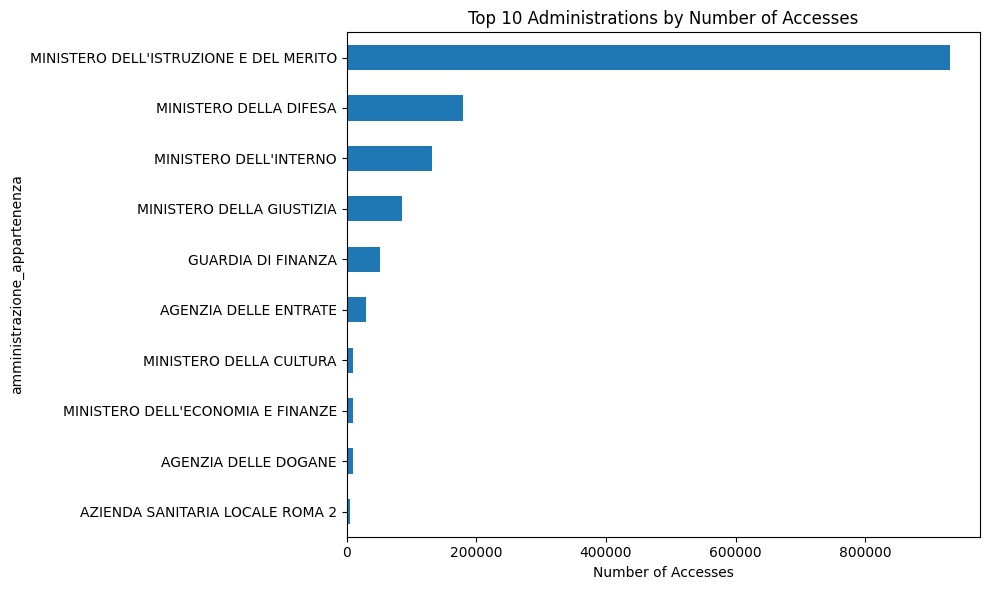

In [127]:
# 1.------------------------------------------------------
## Top regions with the most portal accesses
# Group by region and sum the number of accesses
regioni_accessi = df_accesso.groupby("regione_residenza_domicilio")["numero_occorrenze"].sum().sort_values(ascending=False)

print("\nTop regions by number of accesses:")
print(regioni_accessi.head(10)) 


plt.figure(figsize=(10, 5))
regioni_accessi.head(10).plot(kind='bar')
plt.title("Top 10 Regions by Number of Portal Accesses")
plt.ylabel("Number of Accesses")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Distribution by authentication method
#Count how many times each authentication method was used
modalita_auth = df_accesso.groupby("modalita_autenticazione")["numero_occorrenze"].sum().sort_values(ascending=False)

print("\nAuthentication Method Distribution:")
print(modalita_auth)

#Top 10 administrations by number of accesses
top_amministrazioni = df_accesso.groupby("amministrazione_appartenenza")["numero_occorrenze"].sum().sort_values(ascending=False)

print("\nTop 10 administrations by number of accesses:")
print(top_amministrazioni.head(10))

plt.figure(figsize=(10, 6))
top_amministrazioni.head(10).plot(kind='barh')
plt.title("Top 10 Administrations by Number of Accesses")
plt.xlabel("Number of Accesses")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


### df_stipendi

In [128]:
print(df_stipendi.info())

#Missing values
print("Missing values:")
print(df_stipendi.isnull().sum())
print("\n")
print(df_stipendi.dtypes)

#Gender distribution (%)
print("\nGender distribution (%):")
print(df_stipendi["sesso"].value_counts(normalize=True) * 100)


modalita_counts = df_stipendi.groupby("modalita_pagamento")["numero"].sum()
modalita_percentuali = (modalita_counts / modalita_counts.sum()) * 100
modalita_percentuali = modalita_percentuali.sort_values(ascending=False)
print("Payment method percentages:")
print(modalita_percentuali)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25580 entries, 0 to 25579
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comune_della_sede   25580 non-null  object
 1   amministrazione     25580 non-null  object
 2   eta_min             25580 non-null  int64 
 3   eta_max             25580 non-null  object
 4   sesso               25580 non-null  object
 5   modalita_pagamento  25580 non-null  object
 6   numero              25580 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.4+ MB
None
Missing values:
comune_della_sede     0
amministrazione       0
eta_min               0
eta_max               0
sesso                 0
modalita_pagamento    0
numero                0
dtype: int64


comune_della_sede     object
amministrazione       object
eta_min                int64
eta_max               object
sesso                 object
modalita_pagamento    object
numero                 int64
dty


Top 10 administrations by number of payments:
amministrazione
MINISTERO DELL'ISTRUZIONE E DEL MERITO    1196017
MINISTERO DELLA DIFESA                     188106
MINISTERO DELL'INTERNO                     144245
MINISTERO DELLA GIUSTIZIA                   98466
GUARDIA DI FINANZA                          59384
AGENZIA DELLE ENTRATE                       31480
MINISTERO DELLA CULTURA                     11279
MINISTERO DELL'ECONOMIA E FINANZE           10045
MINISTERO UNIVERSITA' E RICERCA              9382
AGENZIA DELLE DOGANE                         8171
Name: numero, dtype: int64


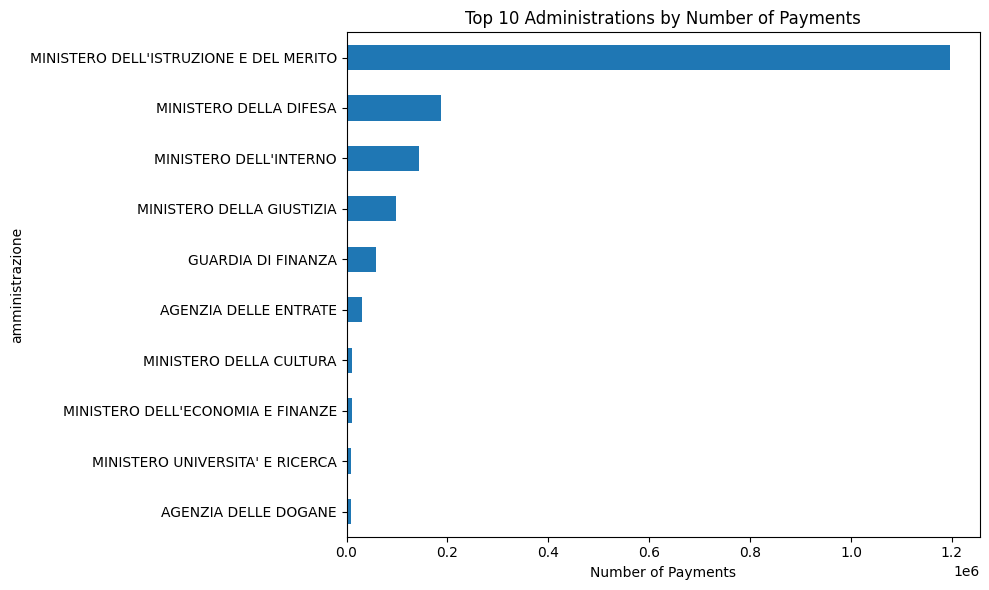


Top 10 municipalities by number of payments:
comune_della_sede
ROMA       390659
NAPOLI      44520
MILANO      38648
TORINO      27345
PALERMO     25951
GENOVA      17682
FIRENZE     15493
CATANIA     15079
BARI        14444
BOLOGNA     13938
Name: numero, dtype: int64


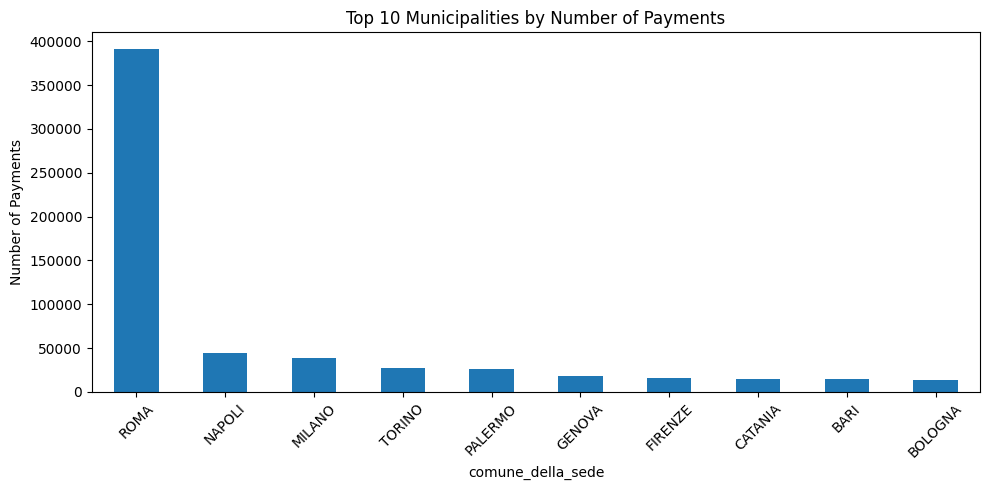

In [129]:
#Administrations paying the most people
admin_pagamenti = df_stipendi.groupby("amministrazione")["numero"].sum().sort_values(ascending=False)

print("\nTop 10 administrations by number of payments:")
print(admin_pagamenti.head(10))

admin_pagamenti.head(10).plot(kind='barh', figsize=(10, 6))
plt.title("Top 10 Administrations by Number of Payments")
plt.xlabel("Number of Payments")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#Total payments per municipality
comuni_pagamenti = df_stipendi.groupby("comune_della_sede")["numero"].sum().sort_values(ascending=False)

print("\nTop 10 municipalities by number of payments:")
print(comuni_pagamenti.head(10))

plt.figure(figsize=(10, 5))
comuni_pagamenti.head(10).plot(kind='bar')
plt.title("Top 10 Municipalities by Number of Payments")
plt.ylabel("Number of Payments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### df_amministrati

In [130]:
print(df_amministrati.info())

#Missing values
print("Missing values:")
print(df_amministrati.isnull().sum())
print("\n")
print(df_amministrati.dtypes)

#Gender distribution (%)
print("\nGender distribution (%):")
print(df_amministrati["sesso"].value_counts(normalize=True) * 100)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comparto            5099 non-null   object
 1   regione_residenza   5099 non-null   object
 2   sesso               5099 non-null   object
 3   eta_min             5099 non-null   int64 
 4   eta_max             5099 non-null   object
 5   aliquota_max        5099 non-null   int64 
 6   fascia_reddito_min  3471 non-null   object
 7   fascia_reddito_max  3376 non-null   object
 8   numerosita          5099 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 358.7+ KB
None
Missing values:
comparto                 0
regione_residenza        0
sesso                    0
eta_min                  0
eta_max                  0
aliquota_max             0
fascia_reddito_min    1628
fascia_reddito_max    1723
numerosita               0
dtype: int64


comparto              object
region

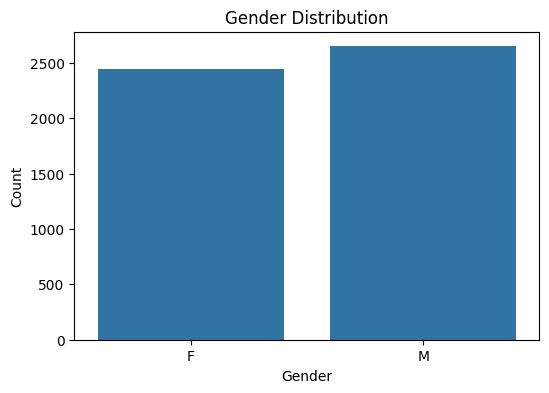

/var/folders/bt/q7p67fmn6n18tt9zx5924xs80000gn/T/ipykernel_80563/2762104149.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_amministrati, y="comparto", order=df_amministrati["comparto"].value_counts().index, palette="Blues_r")


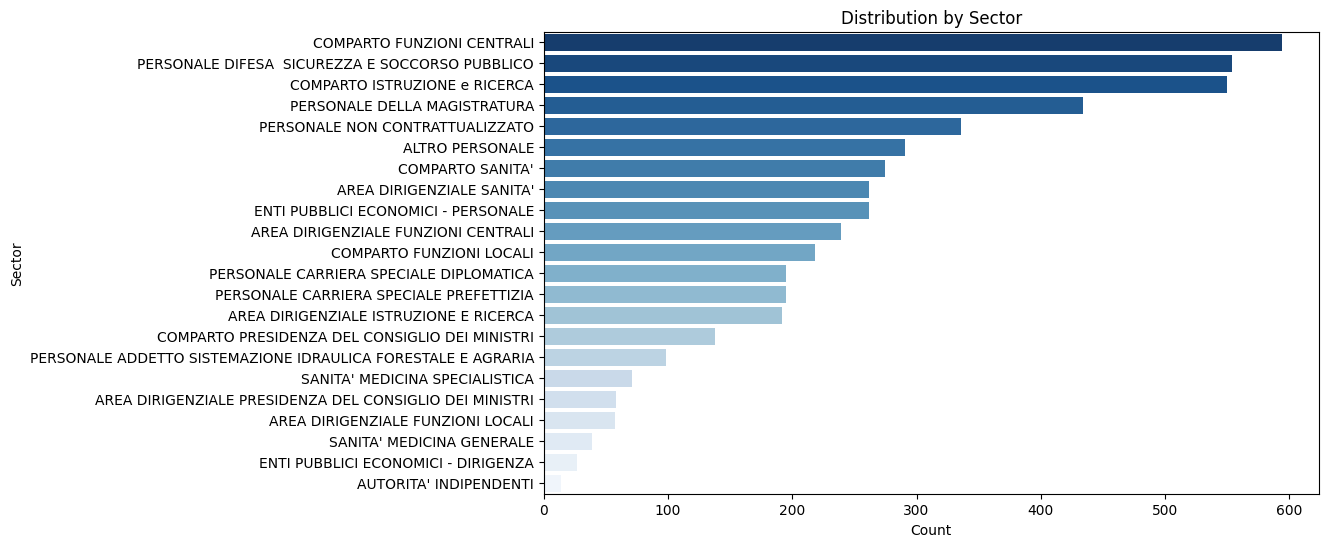

/var/folders/bt/q7p67fmn6n18tt9zx5924xs80000gn/T/ipykernel_80563/2762104149.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_amministrati, y="regione_residenza", order=df_amministrati["regione_residenza"].value_counts().index, palette="Greens_r")


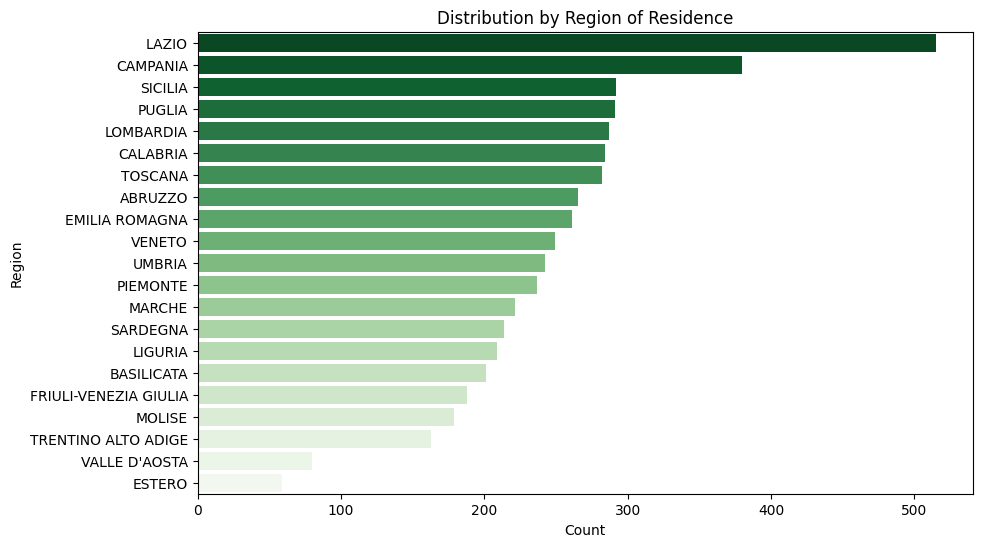

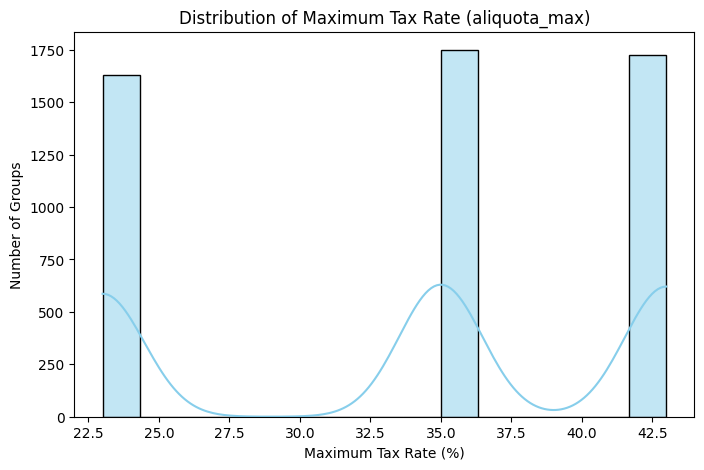

In [131]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_amministrati, x="sesso")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

#Distribution by sector
plt.figure(figsize=(10, 6))
sns.countplot(data=df_amministrati, y="comparto", order=df_amministrati["comparto"].value_counts().index, palette="Blues_r")
plt.title("Distribution by Sector")
plt.xlabel("Count")
plt.ylabel("Sector")
plt.show()

#Distribution by region of residence
plt.figure(figsize=(10, 6))
sns.countplot(data=df_amministrati, y="regione_residenza", order=df_amministrati["regione_residenza"].value_counts().index, palette="Greens_r")
plt.title("Distribution by Region of Residence")
plt.xlabel("Count")
plt.ylabel("Region")
plt.show()

#Distribution of maximum tax rate (aliquota_max)
plt.figure(figsize=(8, 5))
sns.histplot(data=df_amministrati, x="aliquota_max", bins=15, kde=True, color="skyblue")
plt.title("Distribution of Maximum Tax Rate (aliquota_max)")
plt.xlabel("Maximum Tax Rate (%)")
plt.ylabel("Number of Groups")
plt.show()


/var/folders/bt/q7p67fmn6n18tt9zx5924xs80000gn/T/ipykernel_80563/1912279747.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


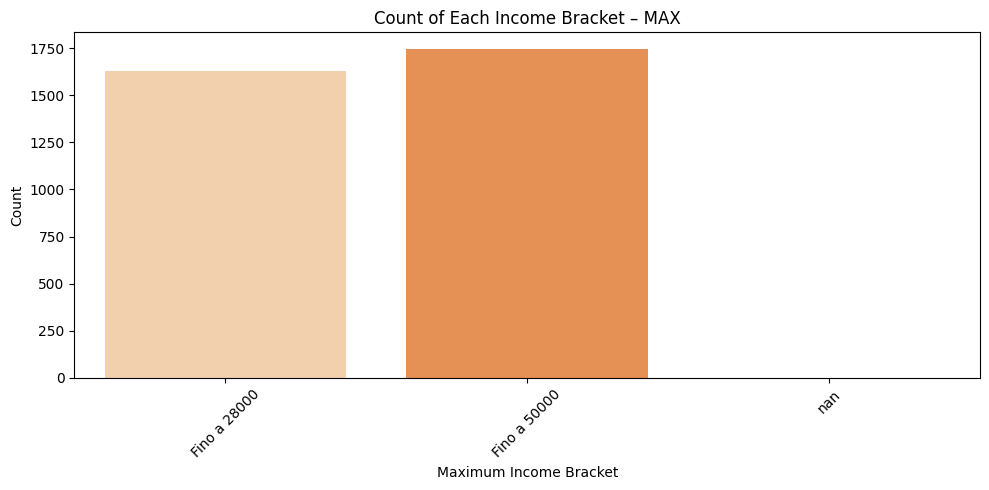

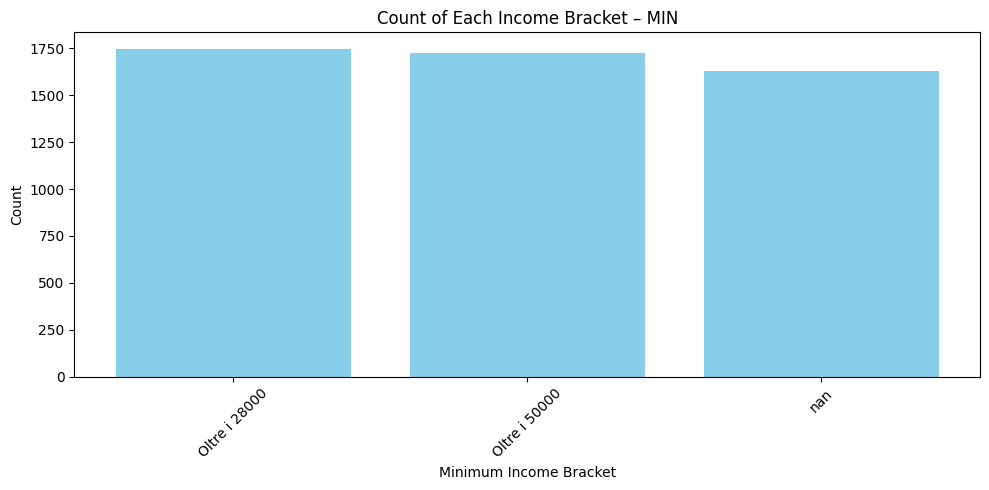

In [132]:
plt.figure(figsize=(10, 5))
sns.countplot(
    data=df_amministrati,
    x="fascia_reddito_max",
    order=sorted(df_amministrati["fascia_reddito_max"].astype(str).str.strip().unique()),
    palette="Oranges"
)
plt.title("Count of Each Income Bracket – MAX")
plt.xlabel("Maximum Income Bracket")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_amministrati["fascia_reddito_min"] = df_amministrati["fascia_reddito_min"].astype(str).str.strip()

count_min = df_amministrati["fascia_reddito_min"].value_counts().sort_index()


plt.figure(figsize=(10, 5))
plt.bar(count_min.index, count_min.values, color="skyblue")
plt.title("Count of Each Income Bracket – MIN")
plt.xlabel("Minimum Income Bracket")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





### df_pendolarismo

In [133]:

print(df_pendolarismo.info())

print("Null Values:")
print(df_pendolarismo.isnull().sum())
print("\n")
print(df_pendolarismo.dtypes)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24842 entries, 0 to 24841
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   provincia_della_sede  24842 non-null  object
 1   comune_della_sede     24842 non-null  object
 2   stesso_comune         24842 non-null  object
 3   ente                  24842 non-null  object
 4   numero_amministrati   24842 non-null  int64 
 5   distance_min_KM       24842 non-null  object
 6   distance_max_KM       24842 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB
None
Null Values:
provincia_della_sede    0
comune_della_sede       0
stesso_comune           0
ente                    0
numero_amministrati     0
distance_min_KM         0
distance_max_KM         0
dtype: int64


provincia_della_sede    object
comune_della_sede       object
stesso_comune           object
ente                    object
numero_amministrati      int64
distance_min_KM       

Distribution of commuters vs non-commuters:
stesso_comune
NO    76.34651
SI    23.65349
Name: count, dtype: float64


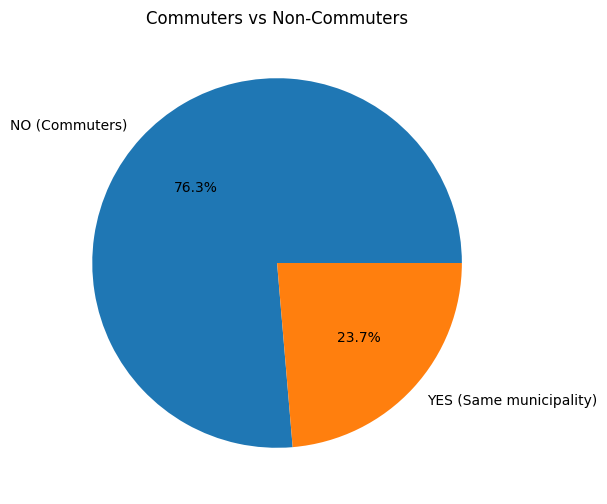


Distribution by distance bracket:
fascia_km
 -5 km        695394
5-10 km       278296
10-20 km      271606
20-50 km      249514
200-600 km    196886
600-  km      179880
50-100 km      87404
100-200 km     59507
Name: numero_amministrati, dtype: int64


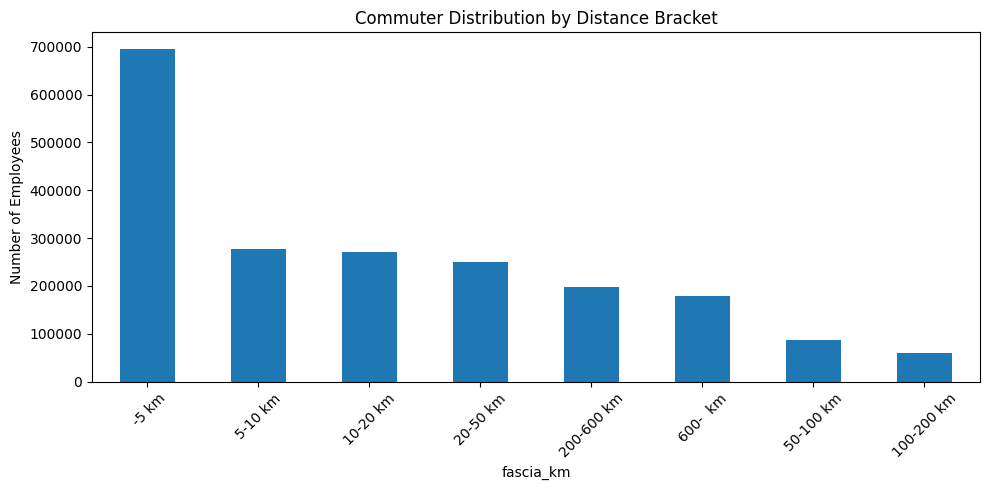


Top 5 provinces by commuting:
provincia_della_sede
ROMA       472660
NAPOLI     102374
MILANO      80600
TORINO      60537
PALERMO     43508
Name: numero_amministrati, dtype: int64

Top 5 organizations by commuting:
ente
MINISTERO DELL'ISTRUZIONE E DEL MERITO    1334223
MINISTERO DELLA DIFESA                     220508
MINISTERO DELL'INTERNO                     163541
MINISTERO DELLA GIUSTIZIA                  110045
GUARDIA DI FINANZA                          65794
Name: numero_amministrati, dtype: int64


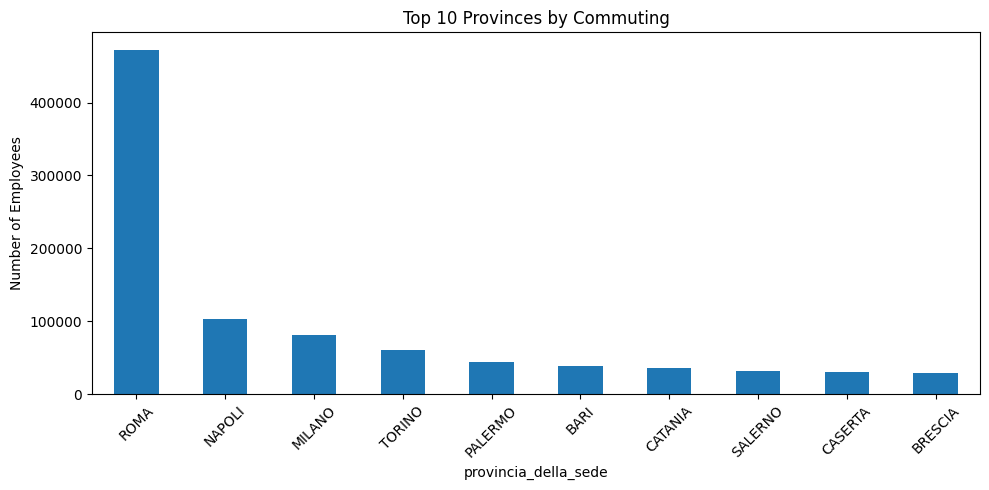

In [134]:
#Percentage of commuters vs non-commuters (stesso_comune)

pendolari = df_pendolarismo["stesso_comune"].value_counts()
pendolari_pct = (pendolari / pendolari.sum()) * 100

print("Distribution of commuters vs non-commuters:")
print(pendolari_pct)

pendolari_pct.plot(kind='pie', autopct='%1.1f%%', labels=['NO (Commuters)', 'YES (Same municipality)'],
                   title="Commuters vs Non-Commuters", figsize=(6, 6))
plt.ylabel("")
plt.show()


#Distribution by distance range (distance_min_KM and distance_max_KM)
df_pendolarismo["fascia_km"] = df_pendolarismo["distance_min_KM"].astype(str) + "-" + df_pendolarismo["distance_max_KM"].astype(str) + " km"

fasce_km = df_pendolarismo.groupby("fascia_km")["numero_amministrati"].sum().sort_values(ascending=False)

print("\nDistribution by distance bracket:")
print(fasce_km)

plt.figure(figsize=(10, 5))
fasce_km.plot(kind='bar')
plt.title("Commuter Distribution by Distance Bracket")
plt.ylabel("Number of Employees")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Commuting by province and organizations
provincia_pendolari = df_pendolarismo.groupby("provincia_della_sede")["numero_amministrati"].sum().sort_values(ascending=False)

ente_pendolari = df_pendolarismo.groupby("ente")["numero_amministrati"].sum().sort_values(ascending=False)

print("\nTop 5 provinces by commuting:")
print(provincia_pendolari.head())

print("\nTop 5 organizations by commuting:")
print(ente_pendolari.head())

plt.figure(figsize=(10, 5))
provincia_pendolari.head(10).plot(kind='bar')
plt.title("Top 10 Provinces by Commuting")
plt.ylabel("Number of Employees")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# remove fasce_km
df_pendolarismo.drop(columns=["fascia_km"], inplace=True)


### cross-dataset EDA

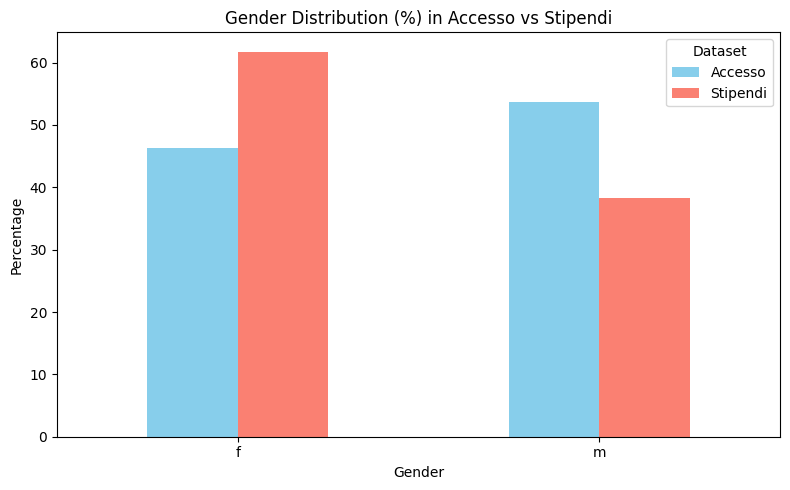

In [135]:
df_accesso["sesso"] = df_accesso["sesso"].astype(str).str.strip().str.lower()
df_stipendi["sesso"] = df_stipendi["sesso"].astype(str).str.strip().str.lower()


gender_accesso = df_accesso["sesso"].value_counts(normalize=True) * 100
gender_stipendi = df_stipendi["sesso"].value_counts(normalize=True) * 100

#Combine in one DataFrame
gender_df = pd.DataFrame({
    "Accesso": gender_accesso,
    "Stipendi": gender_stipendi
}).fillna(0)


gender_df.plot(kind="bar", figsize=(8, 5), color=["skyblue", "salmon"])
plt.title("Gender Distribution (%) in Accesso vs Stipendi")
plt.ylabel("Percentage")
plt.xlabel("Gender")
plt.xticks(rotation=0)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


In [136]:
def clean_region(df, column):
    if column in df.columns:
        return set(df[column].dropna().astype(str).str.strip().str.lower().unique())
    return set()

regions_accesso = clean_region(df_accesso, "regione_residenza")
regions_stipendi = clean_region(df_stipendi, "regione_residenza")
regions_amministrati_reddito = clean_region(df_amministrati, "regione_residenza")
regions_pendolarismo = clean_region(df_pendolarismo, "regione_residenza")

#Compare regions
print("🟠 In ACCESSO but not in STIPENDI:", regions_accesso - regions_stipendi)
print("🟠 In STIPENDI but not in ACCESSO:", regions_stipendi - regions_accesso)
print("🟢 In ACCESSO but not in AMMINISTRATI:", regions_accesso - regions_amministrati_reddito)
print("🟢 In AMMINISTRATI but not in ACCESSO:", regions_amministrati_reddito - regions_accesso)
print("🔵 In PENDOLARISMO but not in AMMINISTRATI:", regions_pendolarismo - regions_amministrati_reddito)
print("🔵 In AMMINISTRATI but not in PENDOLARISMO:", regions_amministrati_reddito - regions_pendolarismo)


🟠 In ACCESSO but not in STIPENDI: set()
🟠 In STIPENDI but not in ACCESSO: set()
🟢 In ACCESSO but not in AMMINISTRATI: set()
🟢 In AMMINISTRATI but not in ACCESSO: {'abruzzo', 'veneto', 'campania', 'puglia', 'emilia romagna', "valle d'aosta", 'estero', 'piemonte', 'umbria', 'toscana', 'sicilia', 'liguria', 'basilicata', 'friuli-venezia giulia', 'calabria', 'lombardia', 'sardegna', 'trentino alto adige', 'lazio', 'marche', 'molise'}
🔵 In PENDOLARISMO but not in AMMINISTRATI: set()
🔵 In AMMINISTRATI but not in PENDOLARISMO: {'abruzzo', 'veneto', 'campania', 'puglia', 'emilia romagna', "valle d'aosta", 'estero', 'piemonte', 'umbria', 'toscana', 'sicilia', 'liguria', 'basilicata', 'friuli-venezia giulia', 'calabria', 'lombardia', 'sardegna', 'trentino alto adige', 'lazio', 'marche', 'molise'}


# Data Preparation
In this section, we perform a crucial data preprocessing step to prepare all four datasets for analysis. The operations include:

**Renaming columns:**
- We translate and standardize all column names across the datasets into English. This ensures:

- Consistency across datasets (e.g., gender, age_min, administration).

- Better compatibility with the agents and code generation tools.

- Easier interpretation by non-Italian users.

**Fixing data types:**

- Several fields (like age_max, income_bracket_min, distance_max_km) were incorrectly stored as strings or floats due to formatting (e.g., "oltre i 28000").

- These are cleaned and converted to proper integer or nullable integer types using pandas.to_numeric() with errors="coerce".

- This avoids errors in future steps like filtering, aggregation, or plotting.

This normalization process is foundational for the system to work, as it ensures that queries referring to age, income, distance, etc., can be correctly interpreted and handled programmatically by the agent tools (e.g., InsightBuilder).





In [154]:
df_accesso.rename(columns={
    'regione_residenza_domicilio': 'region_of_residence',
    'amministrazione_appartenenza': 'administration',
    'sesso': 'gender',
    'eta_max': 'age_max',
    'eta_min': 'age_min',
    'modalita_autenticazione': 'access_method',
    'numero_occorrenze': 'number_of_users'
}, inplace=True)


In [155]:
df_pendolarismo.rename(columns={
    'provincia_della_sede': 'workplace_province',
    'comune_della_sede': 'municipality',
    'stesso_comune': 'same_municipality',
    'ente': 'administration',
    'numero_amministrati': 'number_of_users',
    'distance_min_KM': 'distance_min_km',
    'distance_max_KM': 'distance_max_km'
}, inplace=True)


In [156]:
df_amministrati.rename(columns={
    'comparto': 'organizational_unit',
    'regione_residenza': 'region_of_residence',
    'sesso': 'gender',
    'eta_min': 'age_min',
    'eta_max': 'age_max',
    'aliquota_max': 'max_tax_rate',
    'fascia_reddito_min': 'income_bracket_min',
    'fascia_reddito_max': 'income_bracket_max',
    'numerosita': 'number_of_users'
}, inplace=True)


In [157]:
df_stipendi.rename(columns={
    'comune_della_sede': 'municipality',
    'amministrazione': 'administration',
    'eta_min': 'age_min',
    'eta_max': 'age_max',
    'sesso': 'gender',
    'modalita_pagamento': 'payment_method',
    'numero': 'number_of_payments'
}, inplace=True)


In [158]:
dataframes = {
    "df_stipendi": df_stipendi,
    "df_amministrati": df_amministrati,
    "df_pendolarismo": df_pendolarismo,
    "df_accesso": df_accesso
}

for name, df in dataframes.items():
    print(f"\nData types in {name}:\n{'-' * (18 + len(name))}")
    print(df.dtypes.sort_index())



Data types in df_stipendi:
-----------------------------
administration        object
age_max                Int64
age_min                int64
gender                object
municipality          object
number_of_payments     int64
payment_method        object
dtype: object

Data types in df_amministrati:
---------------------------------
age_max                 Int64
age_min                 int64
gender                 object
income_bracket_max      Int64
income_bracket_min      Int64
max_tax_rate            int64
number_of_users         int64
organizational_unit    object
region_of_residence    object
dtype: object

Data types in df_pendolarismo:
---------------------------------
administration        object
distance_max_km        Int64
distance_min_km        Int64
municipality          object
number_of_users        int64
same_municipality     object
workplace_province    object
dtype: object

Data types in df_accesso:
----------------------------
access_method          object
admini

In [ ]:
import pandas as pd

# --- Fix df_stipendi ---
df_stipendi["age_max"] = pd.to_numeric(df_stipendi["age_max"], errors="coerce").astype("Int64")

# --- Fix df_amministrati ---
df_amministrati["age_max"] = pd.to_numeric(df_amministrati["age_max"], errors="coerce").astype("Int64")

df_amministrati["income_bracket_min"] = (
    df_amministrati["income_bracket_min"]
    .astype(str).str.lower().str.replace("oltre i", "", regex=False)
    .str.replace(".", "", regex=False)
    .str.strip()
)
df_amministrati["income_bracket_min"] = pd.to_numeric(df_amministrati["income_bracket_min"], errors="coerce").astype("Int64")

df_amministrati["income_bracket_max"] = (
    df_amministrati["income_bracket_max"]
    .astype(str).str.lower().str.replace("fino a", "", regex=False)
    .str.replace(".", "", regex=False)
    .str.strip()
)
df_amministrati["income_bracket_max"] = pd.to_numeric(df_amministrati["income_bracket_max"], errors="coerce").astype("Int64")

# --- Fix df_pendolarismo ---
df_pendolarismo["distance_min_km"] = pd.to_numeric(
    df_pendolarismo["distance_min_km"], errors="coerce"
).astype("Int64")

df_pendolarismo["distance_max_km"] = pd.to_numeric(
    df_pendolarismo["distance_max_km"], errors="coerce"
).astype("Int64")

# --- Fix df_accesso ---
df_accesso["age_max"] = pd.to_numeric(df_accesso["age_max"], errors="coerce").astype("Int64")

# --- Print head and dtypes ---
dataframes = {
    "df_stipendi": df_stipendi,
    "df_amministrati": df_amministrati,
    "df_pendolarismo": df_pendolarismo,
    "df_accesso": df_accesso
}

for name, df in dataframes.items():
    print(f"\n{name} HEAD:\n{'-' * (len(name) + 6)}")
    print(df.head())
    print(f"\n{name} DTYPES:\n{'-' * (len(name) + 8)}")
    print(df.dtypes.sort_index())



df_stipendi HEAD:
-----------------
  municipality                          administration  age_min  age_max  \
0  ABANO TERME  MINISTERO DELL'ISTRUZIONE E DEL MERITO       25       34   
1  ABANO TERME  MINISTERO DELL'ISTRUZIONE E DEL MERITO       25       34   
2  ABANO TERME  MINISTERO DELL'ISTRUZIONE E DEL MERITO       35       44   
3  ABANO TERME  MINISTERO DELL'ISTRUZIONE E DEL MERITO       35       44   
4  ABANO TERME  MINISTERO DELL'ISTRUZIONE E DEL MERITO       45       54   

  gender              payment_method  number_of_payments  
0      f  Conto corrente/Carta conto                  31  
1      m  Conto corrente/Carta conto                  18  
2      f  Conto corrente/Carta conto                  56  
3      m  Conto corrente/Carta conto                  18  
4      f  Conto corrente/Carta conto                 115  

df_stipendi DTYPES:
-------------------
administration        object
age_max                Int64
age_min                int64
gender                ob

# Agent Tools: InsightBuilder, CodeRunner, and ResultExplainer
This section defines the three core tools used by our multi-agent system (specifically, by the VisualizationAgent and by the DataProcessingAgent) to process and respond to user queries. These tools enable the agents to understand questions, generate executable code, and provide clear explanations.

**1. InsightBuilder(prompt: str) → str**
- This is the brain behind query interpretation and code generation.
- It receives a natural language question (e.g., “What is the average commuting distance by age group?”).
- It parses the request to dentify relevant variables and datasets, plan the analysis steps (filtering, merging, aggregating, visualizing), and generate a complete and executable Python script to answer the question.
- It follows a standardized workflow that ensures correctness, modularity, and reproducibility, handling everything from ambiguity resolution to plotting.
- It also supports merging datasets when needed, handles missing or mismatched columns, and always returns a full, ready-to-run script.

**2. CodeRunner(code: str) → dict**
- This tool safely executes the Python script generated by InsightBuilder.
- It runs the code inside a controlled namespace with access to all four datasets.
- It captures anything printed during execution and returns it as output.
- If any error occurs during execution, the full traceback is returned for debugging.
- It is designed to be safe, stateless, and compatible with both text-based and visual outputs.

**3. ResultExplainer(code: str, output: str, prompt: str) → str**
- This tool takes the code output and turns it into a natural-language explanation using GPT-4.1.
- It reads the original user query, the generated code, and the output.
- It formats any tables or summaries found in the output.
- It then explains what the result means, in clear, user-friendly English.



In [229]:
@function_tool
def InsightBuilder(prompt: str) -> str:
    """
    ## ROLE:
    You are a tool that 
    - understands a natural-language query, 
		- carefully analyzes the user's request to determine exactly which columns and datasets 
	    are required, and what type of analysis must be performed
	  - generates executable Python code from a natural-language query.
    The output should be a complete, idiomatic, and modular Python script that follows a precise analysis workflow.

    ## STANDARD WORKFLOW: IT IS ALWAYS MANDATORY
    1. Understand ALL the user's requests and intent clearly, **even if there is more than one request you have to make sure to answer all of them.**
    - Identify whether the user is asking for data analysis or visualization.
    - Understand the precise relationship being queried (e.g., correlation, comparison, grouping).
    - If multiple intents are present (e.g. "group and compare") capture ALL of them.

    2. Parse the Natural-Language Prompt
    - Extract the names of ALL AND ONLY the variables that are necessary to respond to the request.
    - Identify which dataset (among df_accesso, df_pendolarismo, df_amministrati, df_stipendi) contains each variable.
    - Determine the nature of the feature (categorical or numeric) and the type of analysis required.
    
    3. Dataset Dictionary (they are available in memory)
    - **df_accesso**: Access records by region, administration, age, gender, and login method  
      Columns:
        • region_of_residence - region where the employee resides  
        • administration - type of administration  
        • gender - employee gender  
        • age_max - maximum age of the employee group  
        • age_min - minimum age of the employee group  
        • access_method - login authentication/access method used  
        • number_of_users - number of users/employees in the group  

    - **df_pendolarismo**: Commuting data by administration and office location  
      Columns:
        • workplace_province - province where the office is located  
        • municipality - municipality of the office  
        • same_municipality - whether residence and office are the same  
        • administration - administration name  
        • number_of_users - number of commuting employees/users
        • distance_min_km - minimum commuting distance in km  
        • distance_max_km - maximum commuting distance in km  

    - **df_amministrati**: Demographic and tax bracket data by region and sector  
      Columns:
        • organizational_unit - organizational unit or sector where the employee works  
        • region_of_residence - region where the employee resides  
        • gender - employee gender  
        • age_min - minimum employee age  
        • age_max - maximum employee age  
        • max_tax_rate - maximum tax rate applied  
        • income_bracket_min - minimum income for the bracket  
        • income_bracket_max - maximum income for the bracket  
        • number_of_users - number of employees per income bracket  

    - **df_stipendi**: Salary records by age, gender, administration and payment method  
      Columns:
        • municipality - municipality of the office  
        • administration - administration type  
        • age_min - minimum employee age  
        • age_max - maximum employee age  
        • gender - employee gender  
        • payment_method - salary payment method  
        • number_of_payments - number of payments processed  

    4. Solve Ambiguity and Column Mismatch
    - If a referenced column doesn't exist in the dataset, match it to the most semantically similar column using string similarity (e.g., "administration" vs. "organization").
    - Warn if multiple columns could match the same label; select the best one based on context or overlap in values.

    5. Code Planning and Structure
    - The Python code you generate must follow a modular, reproducible, and fully executable pipeline. 
    - This structure is mandatory and must be followed in every case, adapting to the feature/target types and datasets involved.
		- Required libraries: pandas, numpy, matplotlib.pyplot, seaborn.
    
    - Structure:
        a. Load and inspect the DataFrames.
		        - Use the four datasets (df_accesso, df_pendolarismo, df_amministrati, df_stipendi) already loaded in memory.
		        - Print the column names of the releant DataFrames to confirm variable presence.
		        - Validate that selected columns exist OR fallback to best-matching ones.
		        - Show a .head() preview for debugging.
        b. Identify the variables.
		        - Clearly mark the feature variable(s) (explanatory, independent, or grouping variable) and the target(s) (outcome, dependent, measured variable), if necessary.
		        - Use .dtypes and value previews to classify each variable.
        c. IF more than one plot is needed to answer to the user request, use ALWAYS subplots. THIS IS MANDATORY.
            - Create the figure with `fig, axs = plt.subplots(...)` and plot all charts into `axs[i]`
           - DO NOT create multiple separate `plt.figure()` instances.
           - Ensure the figure is returned as a single object.

        d. Aggregate the grouping column, if there is one and if it is necessary.
        e. Aggregate the target column (e.g. weighted average by employee count), if necessary.
        g. Compute requested statistics (e.g. Pearson correlation or t-test), if necessary.
        h. Visualize with plots, if necessary.

    6. IF the analysis involves merging two datasets:
	    1. Load both datasets and print their columns.
	    2. Detect join key candidates (matching or semantically similar), and select the one with most shared non-null values. 
        - IMPORTANT: Ignore NaN values, null values, or values that are not present in both datasets.
        - What matters is the correct execution of the code!
	    3. Generate the code.
        JOINS:
        - df_accesso and df_amministrati: join on "region_of_residence"
        - df_accesso and df_stipendi: join on "administration"
        - df_accesso and df_pendolarismo: join on "administration" 
        - df_pendolarismo and df_stipendi: join on "municipality" if the user asks, for example, "by administration" or "for each administration"
            OR on "municipality" if the user asks, for example, "by municipality" or "for each administration"

    
        EXAMPLE: Determines if there is a correlation between the method of portal access and the average commuting distance for each administration.
        1. Calculate the average commuting distance from df_pendolarismo, grouped by administration.
        2. Compute the dominant portal access method per administration from df_accesso.
        3. Merge the two datasets on administration.
        4. Convert the access_method to categorical codes to perform a correlation.
        5. Compute the correlation (e.g. Pearson).


        EXAMPLE OF CODE: Plot the average commuting distance per age group
        ```python
        import matplotlib.pyplot as plt
        df_pendolarismo["avg_km"] = (df_pendolarismo["distance_min_km"] + df_pendolarismo["distance_max_km"]) / 2
        merged = df_pendolarismo.merge(df_stipendi, on=["municipality"], how="inner")
        merged["age_group"] = merged["age_min"].astype(str) + "-" + merged["age_max"].astype(str)
        merged.groupby("age_group")["avg_km"].mean().plot(kind="bar", title="Avg Commute by Age Group", figsize=(10,5))
        plt.ylabel("Average Distance (km)")
        plt.tight_layout()
        plt.show()
        ```
    
    7. Code Quality
    - All column accesses should be guarded with `if col in df.columns`.
    - Use assertions or print statements to confirm key steps.
    - Comments should clearly mark each section of the process.
    - Code must run without external file dependencies (datasets are preloaded).

    8. Validation
    - Validate intermediate steps: print head of merged table, number of groups, etc.

    9. Reiteration on Failure
    - If any required column or computation fails, retry a second time.
    - If you get still an error, raise a clear error and recommend possible column alternatives or clarify user intent.

    10. Final Output
    - Deliver the complete Python code as a string, with no markdown formatting or explanation, that will be executed by CodeRunner(code)..
    - Append a short human-readable summary (e.g. “Correlation between X and Y is 0.12, suggesting a weak linear relationship.")”
    """


In [230]:
@function_tool
def CodeRunner(code: str) -> dict:
    """
    Executes Python code and returns:
      - `output`: everything printed during execution
    """
    buf_out = io.StringIO()
    try:
        plt.close('all')  # reset plot state
        ns = {
            '__builtins__': __builtins__,
            'pd': pd,
            'plt': plt,
            'os': os,
            'np': np,
            'df_accesso': df_accesso,
            'df_pendolarismo': df_pendolarismo,
            'df_amministrati': df_amministrati,
            'df_stipendi': df_stipendi,
        }

        with contextlib.redirect_stdout(buf_out):
            exec(code, ns)

        return {
            'output': buf_out.getvalue().strip(),
        }

    except Exception as e:
        import traceback
        return {
            'output': f"Error: {e}\n{traceback.format_exc()}",
        }



In [231]:
@function_tool
def ResultExplainer(code: str, output: str, prompt: str) -> str:
    """
    Uses GPT-4.1 to turn the code output into a fluent, natural-language explanation.
    All parameters must be provided explicitly.
    Automatically includes the raw output table inside a markdown code block if applicable.
    """
    client = OpenAI()

    # Wrap the output in a code block if it looks like a table (i.e., contains multiple lines and columns)
    def format_output_for_display(raw_output):
        lines = raw_output.strip().split("\n")
        if len(lines) >= 2 and any("|" in line or "\t" in line or line.count(" ") > 3 for line in lines):
            return f"""\n{raw_output.strip()}\n"""
        return raw_output.strip()
    formatted_output = format_output_for_display(output)
    explanation_prompt = f"""
You are a helpful data analyst. A user ran this Python code and received the following result.
Your task is to explain this result in fluent, natural English.

--- USER PROMPT ---
{prompt}

--- PYTHON CODE ---
{code}

--- RAW OUTPUT ---
{formatted_output}

INSTRUCTIONS:
- If the output contains a table, PRINT THE TABLE IN A CLEAN FORMAT using aligned text or markdown (e.g. using triple backticks).
- If it's a single number or set of numbers, clearly describe what they represent.
- ALWAYS show the actual printed output.
- NEVER NEVER NEVER say the chart “couldn't be rendered”
- ONLY COMMENT THE RESULTS, NOT THE CODE. Don't say what worked and what didn't during the execution, just talk about the output!
- Do NOT invent or assume missing visuals — only explain printed outputs.
- Then provide a kind, informative, and concise explanation of what it shows.
"""

    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {
                "role": "system",
                "content": "You are a data analyst who explains outputs in natural, user-friendly English. Always show raw output tables if relevant, returning the WHOLE table."
            },
            {
                "role": "user",
                "content": explanation_prompt
            }
        ],
        temperature=0.3
    )

    return response.choices[0].message.content.strip()



# Multi-Agent System Architecture
This section defines the three core agents of our system, each with a distinct and specialized role. All agents are built using the OpenAI Agent SDK and are designed to cooperate through tool-calling and memory to process complex user queries with minimal ambiguity.

## VisualizationAgent
Role: Generates visualizations based on the user's request.

**Workflow:**
- Uses InsightBuilder to generate full matplotlib code from the query.

- Executes it with CodeRunner to produce the visual.

- Optionally uses ResultExplainer to describe the chart in natural language.

## DataProcessingAgent
Role: Performs statistical or numerical analysis (no plots).

**Workflow:**

- Uses InsightBuilder to generate the analysis code.

- Executes the code with CodeRunner.

- Interprets the result using ResultExplainer for a clean, user-friendly explanation.


## ConversationAgent (Orchestrator)
Role: Understands the user's query and routes it to the appropriate sub-agent(s).

- Maintains a token-aware memory buffer of previous user interactions.

- Automatically interprets vague or follow-up queries using conversation history.

**Routing Rules:**

- If the query requires only text → forward to DataProcessingAgent

- If the query requires only a plot → forward to VisualizationAgent

- If it requires both (e.g., "plot and explain") → call both agents and return combined output


This architecture enables rich, modular, and conversational interaction with real-world data — without requiring users to write any code.





In [233]:
visualization_agent = Agent(
    name="VisualizationAgent",
    instructions=(
        """
        ## ROLE
        You are a specialized agent for generating visualizations based on user requests.
        Your task is to generate a visualization (matplotlib chart) based on the user's request.

        ## STANDARD WORKFLOW: IT IS ALWAYS MANDATORY
        1. Use `InsightBuilder(prompt=query)` to 
           - deeply understand the user request, 
           - identify the relevant datasets and the relevant columns, 
           - generate the FULL Python code for plotting
        2. Execute the code using `CodeRunner(code)` to return the chart.
        3. If useful or requested use ResultExplainer(code=..., output=..., prompt=query) to provide a natural-language explanation of the chart.
        3. If the chart is empty or invalid, explain that clearly and politely.
        
        ## RULES
        - MAKE SURE YOU ALWAYS ANSWER TO ALL REQUESTS, NOT JUST ONE.
        - NEVER skip code execution.
        - ALWAYS return a visual output.
        - If not only a simple plot request, but also insight is requested, **ensure you return both the chart and a meaningful explanation of it.**
        - Always choose the visualization type, group-by, or filter that provides the clearest insight given the user request.
        - If multiple chart types are valid (e.g., grouped bar vs. line), select the one that best shows category differences or trends.
        - If multiple datasets are needed, make sure to merge or combine them correctly.
        - If the user has not specified a filter (e.g. age group), default to “include all” unless doing so would clutter the visual excessively.
        - You are the expert — act autonomously. NEVER ask the user to disambiguate.

        ## UNCERTAINTY HANDLING
        - If the user query is ambiguous, incomplete, or could support multiple visual styles or groupings:
            → DO NOT ask the user to clarify.
            → DO NOT delay execution or return fallback text.
            → INSTEAD, use your best judgment based on:
                - common-sense defaults,
                - available columns,
                - the structure of the dataset,
                - and the most informative visual for the type of data.

        ## OUTPUT FORMAT
        - A properly rendered matplotlib chart is MANDATORY.
        - Insight (textual explanation) can be included if helpful or requested, but it is not strictly mandatory.
        """
        ),
        model="gpt-4.1",
        tools=[
            InsightBuilder, CodeRunner, ResultExplainer]
)

# ----- ANALYSIS AGENT -----
data_processing_agent = Agent(
    name="DataProcessingAgent",
    instructions=(
        """
        ## ROLE
        You are a specialized agent for performing data analysis tasks (NOT visualization).
        Your task is to generate, execute, and explain the result of a Python-based analysis, based on the user's request
        
        ## STANDARD WORKFLOW: IT IS ALWAYS MANDATORY
        1. Use `InsightBuilder(prompt=query)` to 
           - deeply understand the user request, 
           - identify the relevant datasets and the relevant columns, 
           - generate the FULL Python code for the analysis
        2. Execute the code using `CodeRunner(code)` to get the result and provide a natural-language explanation.
        3. Use ResultExplainer(code=..., output=..., prompt=query) to provide a natural-language explanation of the output.

        
        ## RULES
        - MAKE SURE YOU ALWAYS ANSWER TO ALL REQUESTS, NOT JUST ONE.

        - NEVER skip code execution. DO NOT skip steps.
        - ALWAYS return a textual output.
        - DO NOT output the Python code.
        - DO NOT describe the code or how it works.
        - DO NOT comment on assumptions, uncertainty, or the pipeline itself.
        - IMPORTANT: if the result is a table, you MUST include the table(s) WITH the explanation.

        ## UNCERTAINTY HANDLING
        - If the user query is ambiguous, incomplete, or could support multiple visual styles or groupings:
            → DO NOT ask the user to clarify.
            → DO NOT delay execution or return fallback text.
            → INSTEAD, use your best judgment based on:
                - common-sense defaults,
                - available columns,
                - the structure of the dataset,
                - and the most informative visual for the type of data.


        ## OUTPUT
        - Your final output must be a clean, natural-language explanation of the result, returned by `ResultExplainer`.
        - It must be fluent, concise, and easy to understand — suitable for a non-technical user.
        - If the result is a table, return also the table with the explanation, describing what the table shows and any important trends or values.
        - If the result is a number, explain what it represents.
        - If the result is empty, explain that clearly and politely.
        """
    ),
    model="gpt-4.1",
    tools=[InsightBuilder, CodeRunner, ResultExplainer]
)

# ----- CONVERSATION AGENT (ORCHESTRATOR) -----
conversation_agent = Agent(
    name="ConversationAgent",
    instructions=(
        """ 
        ## ROLE
        You are a specialized agent for understanding user requests and routing them to the appropriate sub-agent (DataProcessingAgent or VisualizationAgent or both).
        
        ## MEMORY-AWARE INTELLIGENCE
        - You ALWAYS have access to the list of previous user queries (memory buffer).
        - If the current query is ambiguous, short, or refers to something mentioned earlier (e.g. "and now group it", "do the same for gender", "plot that"), you MUST use the memory buffer to reconstruct the user's intent.
        - You must understand the semantic relationship between the current and previous questions.
        - Treat the memory buffer as contextual history: leverage it to disambiguate vague references, maintain continuity, and follow up accurately.
        - DO NOT ask the user to rephrase. YOU must infer what they mean.

        ## INSTRUCTIONS:
        - Analyze user prompts to determine intent.
        - Your job is to detect whether the prompt requires:
            A. Insights → route to DataProcessingAgent
            B. Visuals → route to VisualizationAgent
            C. BOTH → You MUST:
                1. Call VisualizationAgent with the full prompt to generate the chart
                2. Wait for its result and print it first
                3. Then, call DataProcessingAgent with the SAME prompt
                4. RETURN BOTH RESULTS
        ROUTING CRITERIA:
        - DataProcessor: Prompts requesting statistics, comparisons, or textual summaries.
        - Visualizer: Prompts requesting plots, charts, graphs, or any form of data visualization.
        - BOTH: Prompts that require both a chart and a deep analysis.
        EXAMPLES OF SIGNAL WORDS
        - Visual-only → plot, bar chart, draw, graph, visualize, show, histogram, scatter
        - Insight-only → explain, difference, analyze, distribution, interpret, summarize, correlation, compare
        - BOTH → any mix of the above

        ## UNCERTAINTY HANDLING
        - If the user query is ambiguous, incomplete, or could support multiple visual styles or groupings:
            → DO NOT ask the user to clarify.
            → DO NOT delay execution or return fallback text.
            → INSTEAD, use your best judgment based on:
                - common-sense defaults,
                - available columns,
                - the structure of the dataset,
                - and the most informative visual for the type of data.

        ## OUTPUT
        - Forward only the final result from sub-agents.
        - Forward the combined output (explanation + chart) if both were needed. Otherwise, just return the result of the single relevant agent.
        - Ensure outputs are concise, relevant, and devoid of extraneous information.
        """
    ),
    model="gpt-4.1",
    handoffs=[data_processing_agent, visualization_agent]
)


# Memory Management: Token-Aware Buffer
This section defines a token-aware memory system to manage the conversational context passed to the agent.

**agent_with_memory(user_query, agent, memory_buffer, max_token_length=3000)**
- This asynchronous function keeps track of previous queries and ensures that the total conversation history does not exceed the token limit (default: 3000 tokens).

**Key Features:**
- Dynamic truncation: If the total token count of the memory exceeds the threshold, the oldest entries are removed.

- Context retention: It prepends the user's current question with a summary of prior queries (when available), helping the agent answer follow-up questions coherently.

- Flexible return: Returns both the agent's response and the updated memory buffer, ensuring state can be maintained across turns.

**How it works:**
- Adds the new user query to the memory buffer.
- Counts the total tokens using tiktoken encoding (cl100k_base).
- Truncates the oldest messages until the context fits within the allowed token budget.
- Builds a full_query combining past and current inputs.
- Sends it to the Runner.run(agent, full_query) and returns the result.
- This mechanism ensures agents remain aware of past interactions without exceeding model input limits—ideal for building long, interactive conversations.




In [232]:
encoding = tiktoken.get_encoding("cl100k_base")  

def count_tokens(text: str) -> int:
    return len(encoding.encode(text))

async def agent_with_memory(user_query: str, agent, memory_buffer: list, max_token_length=3000):
    """
    Token-aware memory: truncate the memory buffer based on the total number of tokens.
    """
    memory_buffer.append(user_query)

    while True:
        full_memory_text = "\n".join(memory_buffer)
        if count_tokens(full_memory_text) <= max_token_length:
            break
        memory_buffer.pop(0)

    past_context = "\n".join(memory_buffer[:-1]) 
    full_query = (
        f"Old context (summary of previous questions):\n{past_context}\n\n"
        f"New question:\n{user_query}"
    ) if past_context else user_query

    result = await Runner.run(agent, full_query,max_turns=20)

    if isinstance(result.final_output, str):
        return {
            "output": result.final_output,
            "memory_buffer": memory_buffer
        }

    if isinstance(result.final_output, dict):
        result["memory_buffer"] = memory_buffer
        return result

    return {
        "output": f" Unexpected result type: {type(result.final_output)}",
        "memory_buffer": memory_buffer
    }



# Streamlit
This is the command you can run to open streamlit and try our agents!

In [228]:
!streamlit run app.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8530
  Network URL: http://192.168.1.6:8530

  For better performance, install the Watchdog module:

  $ xcode-select --install
  $ pip install watchdog
            
OpenAI API key set: True
^C
  Stopping...
  Stopping...
2025-05-14 16:13:04.677 503 GET /_stcore/health (::1) 0.65ms
